# Long Context Fine-tuning for Summarization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Summarization_LongContext_Finetuning.ipynb)

## Introduction

An important use-case for LLMs is summarization, where we can pass in large source documents into the context window of the LLM and prompt it to generate comprehensive summaries.

For most LLMs this works quite well for source documents below cumulative size of 32,000 tokens, however depending on the LLM and how much long context post-training it has had summarization performance of longer documents can perform quite poorly.

In this notebook we will:
1. Discuss a dataset to improve long context summarization.
2. Evaluate how well an LLM summarizes long documents.
3. Fine-tune the LLM to improve summarization capabilities.
4. Compare un-tuned vs. fine-tuned models for summarization.

<img src="images/summary_task.png" height="500">

## Install Libraries

In [ ]:
!pip install -q together==1.3.4
!pip install -q evaluate
!pip install -q orjson
!pip install -q seaborn matplotlib numpy
!pip install -q rouge_score==0.1.2
!pip install -q sacrebleu==2.4.3

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
from together import Together

import orjson
import numpy as np
import os
import pandas as pd

from evaluate import load

TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")

client = Together(api_key = TOGETHER_API_KEY)

def llm_call(query, model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"):
    response = client.chat.completions.create(
        model=model,
        messages=[
          {"role": "system", "content": "You are a helpful chatbot."},
          {"role": "user", "content": query},
        ],
        temperature=1.0,
        seed=42,
        max_tokens=1200,
    )
    result = response.choices[0].message.content
    return result

## Dataset for Summarization Finetuning

We fine-tuned a Llama 3.1 8B baseline model on multiple datasets:
- Synthetic dataset: generated using Llama 3.1 405B
- [GovReport](https://gov-report-data.github.io/): Consists of reports + summaries written by government research agencies

The goal of these datasets was to train the model to generate coherent and comprehensive summaries of long documents ranging from `32,000` to `128,000` tokens.

## Finetune Llama 3.1 8B for Summarization

In [ ]:
# We used the function to launch fine-tuning jobs on the Together platform

def send_ft_job(client,
                model="meta-llama/Meta-Llama-3.1-8B-32k-Instruct-Reference",
                n_epochs=4,
                run_name='1113-summarization-long-context-finetune',
                train_on_inputs=False,
                learning_rate=6e-5,
                filename=None,
                summarization_file_id=None):
    """
    Sends a fine-tuning job to the client.
    Parameters:
        client (object): The client object to interact with the API.
        model (str): The model to be fine-tuned. Default is "meta-llama/Meta-Llama-3.1-8B-32k-Instruct-Reference".
        n_epochs (int): Number of epochs for fine-tuning. Default is 4.
        run_name (str): The name for the run. Default is '1113-summarization-long-context-finetune'.
        train_on_inputs (bool): Whether to train on inputs. Default is False.
        learning_rate (float): The learning rate for fine-tuning. Default is 6e-5.
        filename (str, optional): The filename to upload for fine-tuning. Default is None.
        summarization_file_id (str, optional): The file ID for summarization. Must be provided if filename is None.
    Returns:
        str: The ID of the fine-tuning job.
    Raises:
        AssertionError: If neither filename nor summarization_file_id is provided.
    """
    if filename:
        response = client.files.upload(filename, check=False)
        summarization_file_id = response.id
    else:
        assert summarization_file_id is not None, "provide summarization_file_id"

    response = client.fine_tuning.create(
        training_file = summarization_file_id,
        model = model,
        n_epochs = n_epochs,
        n_checkpoints = 1,
        batch_size = "max",
        learning_rate = learning_rate,
        warmup_ratio = 0.05,
        suffix=run_name,
        wandb_api_key = WANDB_API_KEY,
        lora=True,
        lora_r=32,
        lora_alpha=64,
        lora_dropout=0.05,
        train_on_inputs=train_on_inputs,
    )
    summarization_fine_tuning_job_id = response.id
    return summarization_fine_tuning_job_id

In [ ]:
# Example fine-tuning job on the synthetic summarization dataset

summarization_fine_tuning_job_id = send_ft_job(
    client,
    model="meta-llama/Meta-Llama-3.1-8B-32k-Instruct-Reference",
    learning_rate=7e-5,
    n_epochs=4,
    filename="1112_summarization_train.jsonl",
    run_name="1112-summarization-synthetic-no-loss-masking",
    summarization_file_id=None,
    train_on_inputs=True,
)

# Example fine-tuning job on GovReport dataset

summarization_fine_tuning_job_id = send_ft_job(
    client,
    model="meta-llama/Meta-Llama-3.1-8B-32k-Instruct-Reference",
    n_epochs=2,
    filename="1114_govreport.jsonl",
    run_name="1114-govreport-2ep",
    summarization_file_id=None,
    train_on_inputs=False,
    learning_rate=4e-5,
)

## Deploy Fine-tuned Models on a Dedicated Endpoint(DE)

Before we can run the evaluations we need to deploy our finetuned model as a Dedicated Endpoint(DE). After fine-tuning completes, access your model through the Together AI dashboard. Go to Models, select your fine-tuned model, and select Deploy. Choose from the available hardware options - we'll use a single A100-80GB GPU for this example.

<img src="images/deploy_CFT.png" height="650">

Once the models are deployed we can use the code below to generate predictions using the dedicated endpoints along with normal serverless inference for the baseline Llama 3.1 8B model.

In [ ]:
def get_predictions(test_items, model):
    predictions = []
    for it in tqdm(test_items):
        predictions.append(
            llm_call(it['prompt'],
                     model=model
                    )
        )
    return predictions

## Evaluate Summarization

We will now compare and score the summarization capabilities of a baseline Llama 3.1 8B vs fine-tunes thereof.

We have provided pre-generated summaries from fine-tuned and baseline Llama 3.1 8B models to simplify comparision below:

In [11]:
predictions = orjson.loads(Path("datasets\predictions.json").read_bytes())

predictions_baseline_syn = predictions['predictions_baseline_syn']
predictions_baseline_govreport = predictions['predictions_baseline_govreport']

In [12]:
predictions_ft = orjson.loads(Path("datasets\predictions_ft.json").read_bytes())

predictions_ft_syn = predictions_ft['predictions_ft_syn']
predictions_ft_govreport = predictions_ft['predictions_ft_govreport']

In [ ]:
test_items = orjson.loads(Path("datasets\synth_summarization_test.json").read_bytes())

test_items_govreport = [orjson.loads(line) for line in Path("datasets\govreport_test.jsonl").read_text().split("\n")]
test_items_govreport = test_items_govreport[:100]

In [5]:
BASELINE_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"

We will use BLEU and ROUGE scores to evaluate between the baseline and fine-tuned Llama 3.1 8B models.

**BLEU (Bilingual Evaluation Understudy)** is a metric that measures the quality of generated text by comparing it against one or more reference texts. Originally developed for machine translation, but now widely used in summarization tasks, BLEU works by counting matching sequences of words (n-grams) between the generated and reference texts. The score ranges from 0 to 1, where higher scores indicate better overlap with the reference text. For example, if a generated summary shares many of the same words and phrases with the reference summary, it will receive a higher BLEU score.

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** is a set of metrics specifically designed to evaluate automatic summarization and machine translation systems by comparing generated text against reference summaries. Unlike BLEU, which focuses on precision, ROUGE emphasizes recall - measuring how much of the reference summary is captured in the generated text. The most commonly used variants are ROUGE-N (measuring n-gram overlap), ROUGE-L (looking at longest common subsequences), and ROUGE-S (considering skip-grams). For example, if a human-written reference summary contains key phrases that also appear in the machine-generated summary, ROUGE will assign higher scores. Scores range from 0 to 1, with 1 indicating perfect overlap. ROUGE has become an industry standard because it correlates well with human judgments, though like BLEU, it has limitations - it can't fully capture semantic meaning or summary coherence, and relies heavily on exact word matches. This is why practitioners often report multiple ROUGE variants alongside other metrics for a more complete evaluation.

In [13]:
# Load in the BLEU and ROUGE metrics from the evaluate HuggingFace library

gleu = load("google_bleu")
rouge = load("rouge")

In [26]:
def compute_gleu(predictions, test_items):
    scores = []
    for p, it in zip(predictions, test_items):
        scores.append(gleu.compute(predictions=[p], references=[[it['completion']]])['google_bleu'] * 100)
    return scores

def compute_rouge_l(predictions, test_items):
    scores = rouge.compute(predictions=predictions, references=[it['completion'] for it in test_items],
                           rouge_types=['rougeL'], use_aggregator=False)['rougeL']
    scores = np.array(scores) * 100
    return scores

In [28]:
for k, (predictions_, test_items_) in zip(
    ["Synthetic Baseline:", "Synthetic Fine-tune:", "GovReport Baseline:", "GovReport Fine-tune:"],
    [(predictions_baseline_syn, test_items), (predictions_ft_syn, test_items),
     (predictions_baseline_govreport, test_items_govreport), (predictions_ft_govreport, test_items_govreport),]
):
    bleu_scores = compute_gleu(predictions_, test_items_)
    rouge_scores = compute_rouge_l(predictions_, test_items_)
    print(k, f"BLEU: {np.mean(bleu_scores):.2f}", f"ROUGE: {np.mean(rouge_scores):.2f}")

Synthetic Baseline: BLEU: 13.49 ROUGE: 21.56
Synthetic Fine-tune: BLEU: 16.10 ROUGE: 23.55
GovReport Baseline: BLEU: 14.30 ROUGE: 21.66
GovReport Fine-tune: BLEU: 21.76 ROUGE: 24.05


As you can see, fine-tuned model results exhibit better performance in all cases.

Let's see examples that improved the most after fine-tuning.

In [ ]:
scores1 = compute_gleu(predictions_baseline_govreport, test_items_govreport)
scores2 = compute_gleu(predictions_ft_govreport, test_items_govreport)
score_differences = np.array(scores2) - np.array(scores1)

In [ ]:
predictions_baseline_govreport[20]

"The report outlines the U.S. Department of Agriculture's (USDA) efforts to improve customer service and reduce administrative costs through the establishment of business centers in its eight mission areas. The report highlights both positive results, such as savings from reducing the size of the USDA's vehicle fleet, and areas for improvement, including staffing vacancies and employee concerns. The business centers were established in response to a 2017 memorandum from the Secretary of Agriculture that aimed to improve customer engagement, maximize efficiency, and improve agency collaboration.\n\nThe report highlights various metrics and goals established for certain administrative services, but notes that the department has not systematically assessed the effectiveness and impact of the business center reforms. The report makes a recommendation that the Secretary of Agriculture direct Departmental Administration to work with the mission areas to develop department-level performance g

In [ ]:
predictions_ft_govreport[20]

"Since November 2017, USDA, through an effort called the Business Center Reform Initiative, has consolidated administrative services in eight of its mission areas and established business centers to provide those services on a shared strategy. Regulations—and institutional knowledge—have not kept pace with these organizational changes. GAO was asked to provide information on the keys to a successful performance management system. This report examines: (1) USDA's status in establishing business centers as reform efforts call for. (2) The status of USDA's efforts to assess the effectiveness and impact of business centers. To conduct its work for this report, GAO reviewed relevant statutes, regulations, and documentation; analyzed mission area reports as they related to administration of the centers; analyzed data that USDA has collected on administrative services; and interviewed USDA staff and representatives of stakeholders. The U.S. Department of Agriculture (USDA) established busines

In [ ]:
test_items_govreport[20]['completion']

"With budget authority of $146 billion in fiscal year 2018, USDA employs nearly 100,000 people organized into 13 major staff offices and eight mission areas comprising 18 agencies. In a November 2017 memorandum, the Secretary of Agriculture called for establishment of a business center in each mission area to provide consolidated administrative services. The memorandum identified three policy goals for these reforms: (1) improve customer engagement, (2) maximize efficiency, and (3) improve agency collaboration. The Agriculture Improvement Act of 2018 includes a provision for GAO to report on USDA's business centers. Among other things, this report examines the extent to which USDA has (1) established business centers and (2) assessed the effectiveness and impact of these business centers. GAO reviewed USDA documents and interviewed officials from USDA's Office of the Assistant Secretary for Administration, Office of Budget and Program Analysis, and eight mission areas about their effor

Text(0.5, 12.44444444444443, 'GovReport fine-tuned - GovReport baseline')

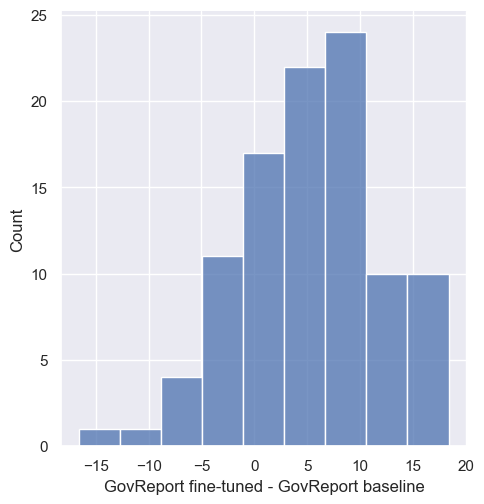

In [ ]:
sns.displot(score_differences)
plt.xlabel("GovReport fine-tuned - GovReport baseline")

As we see in the score differential distribution above(the majority of our test datapoints improve after fine-tuning) we can significantly improve the summarization capabilities of LLMs by finetuning on long context datasets for realworld applications such as summarization.

To learn more about our fine-tuning API read the docs [here](https://docs.together.ai/reference/finetune)!